# Ejemplo 1: Conceptos básicos de análisis de datos espaciales en Python



In [33]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats

## Ingreso de datos

* Raster:

In [5]:
zona_estudio = rasterio.open("Datos/Raster_Stack_Raw.tif")
zona_estudio.crs

CRS.from_epsg(32721)

In [6]:
zona_estudio.shape

(10888, 8014)

* Vector:

In [7]:
poligonos = gpd.read_file("Datos/Polygons.shp")
poligonos.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Podemos realizar reproyecciones para realizar operaciones espaciales entre raster y vector:

In [8]:
poligonos = poligonos.to_crs(zona_estudio.crs)
poligonos.crs

<Projected CRS: EPSG:32721>
Name: WGS 84 / UTM zone 21S
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 21S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Encabezado de los datos:

In [9]:
poligonos.head()

,id,Coverage,geometry
0,26,Crop,"POLYGON ((514072.491 8905988.962, 514580.247 8..."
1,0,Forest,"POLYGON ((553905.969 8998151.569, 558174.969 8..."
2,1,Forest,"POLYGON ((560912.967 8984918.787, 563208.398 8..."
3,2,Forest,"POLYGON ((551468.194 8967101.081, 553769.497 8..."
4,3,Forest,"POLYGON ((509204.957 8922387.698, 511695.607 8..."


Visualización:

In [ ]:
#poligonos.explore(column="Coverage")

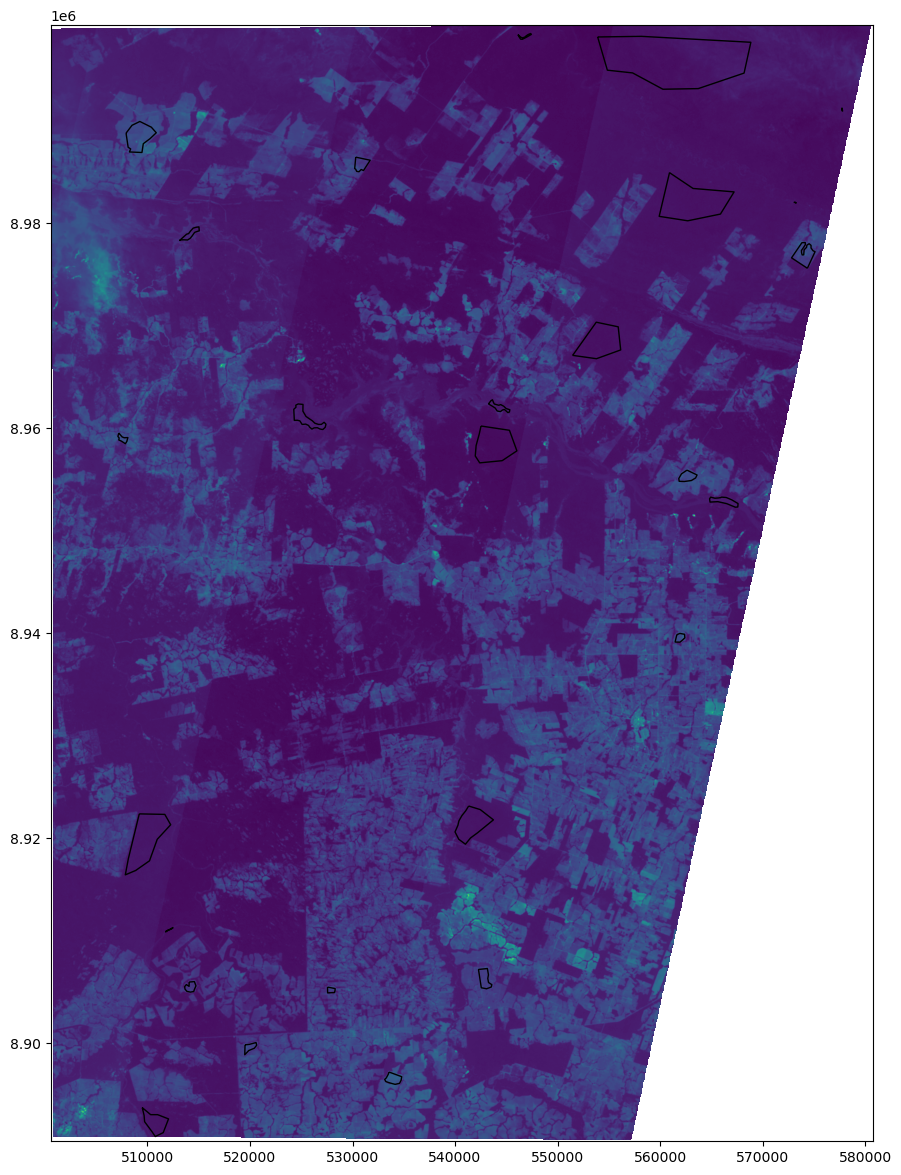

In [10]:
# Original
fig, ax = plt.subplots(figsize=(14.5, 14.5))
rasterio.plot.show(zona_estudio, ax=ax)
poligonos.plot(ax=ax, color='none', edgecolor='black');

## Mask

In [11]:
out_image_mask, out_transform_mask = rasterio.mask.mask(
    zona_estudio, 
    poligonos.geometry, 
    crop=False, 
    nodata=9999
)

In [12]:
dst_kwargs = zona_estudio.meta
dst_kwargs.update(nodata=9999)
dst_kwargs["dtype"] = "uint16"
dst_kwargs

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 9999,
 'width': 8014,
 'height': 10888,
 'count': 13,
 'crs': CRS.from_epsg(32721),
 'transform': Affine(10.0, 0.0, 500570.0,
        0.0, -10.0, 8999340.0)}

In [13]:
new_dataset = rasterio.open('Datos/zona_estudio_masked.tif', 'w', **dst_kwargs)
new_dataset.write(out_image_mask)
new_dataset.close()

In [14]:
zona_estudio_mask = rasterio.open('Datos/zona_estudio_masked.tif')
zona_estudio_mask.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 9999.0,
 'width': 8014,
 'height': 10888,
 'count': 13,
 'crs': CRS.from_epsg(32721),
 'transform': Affine(10.0, 0.0, 500570.0,
        0.0, -10.0, 8999340.0)}

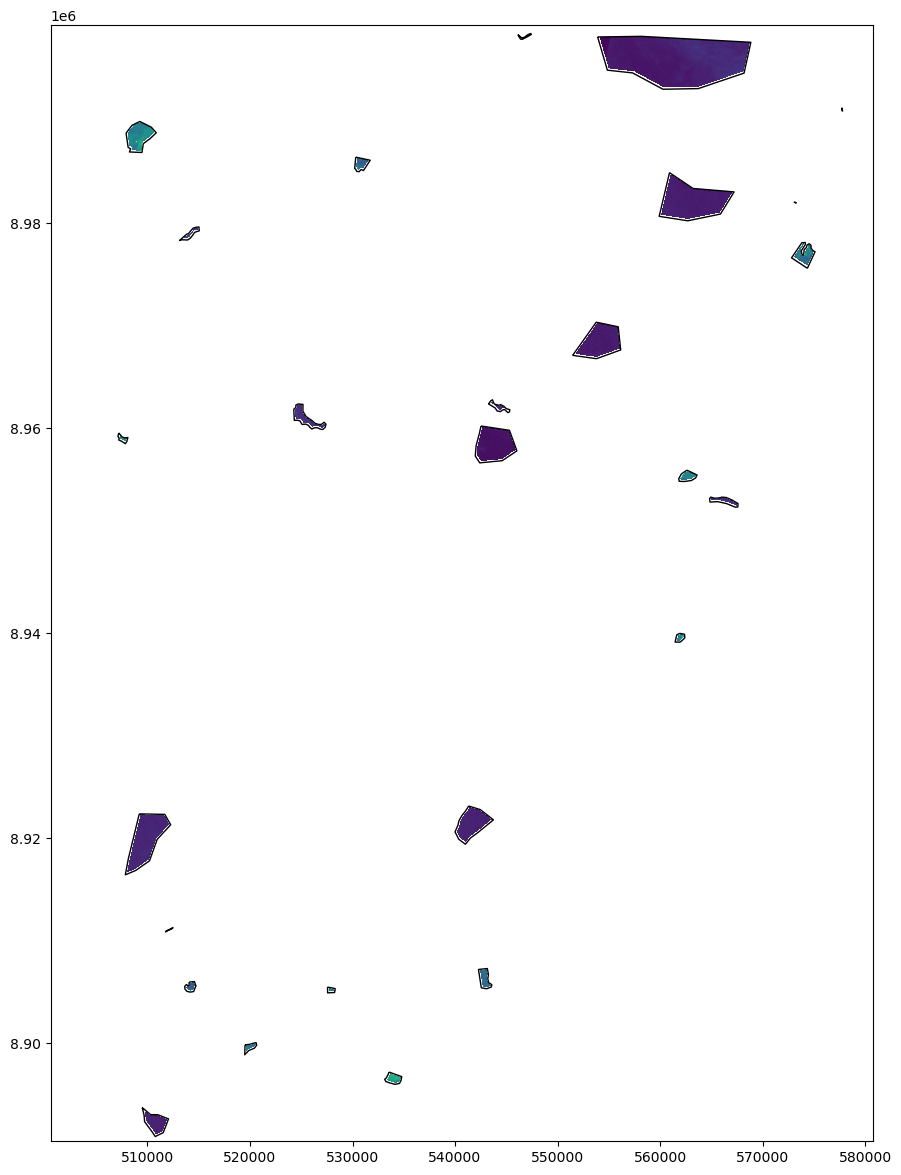

In [15]:
# Masked
fig, ax = plt.subplots(figsize=(14.5, 14.5))
rasterio.plot.show(zona_estudio_mask, ax=ax)
poligonos.plot(ax=ax, color='none', edgecolor='black');

## Crop

In [18]:
out_image_crop, out_transform_crop = rasterio.mask.mask(
    zona_estudio, 
    poligonos.geometry, 
    crop=True, 
    nodata=9999
)

In [21]:
dst_kwargs = zona_estudio.meta
dst_kwargs.update({
    'nodata': 9999,
    'transform': out_transform_crop,
    'width': out_image_crop.shape[2],
    'height': out_image_crop.shape[1]
})
new_dataset = rasterio.open(
    'Datos/zona_estudio_cropped.tif', 
    'w', 
    **dst_kwargs
)
new_dataset.write(out_image_crop)
new_dataset.close()

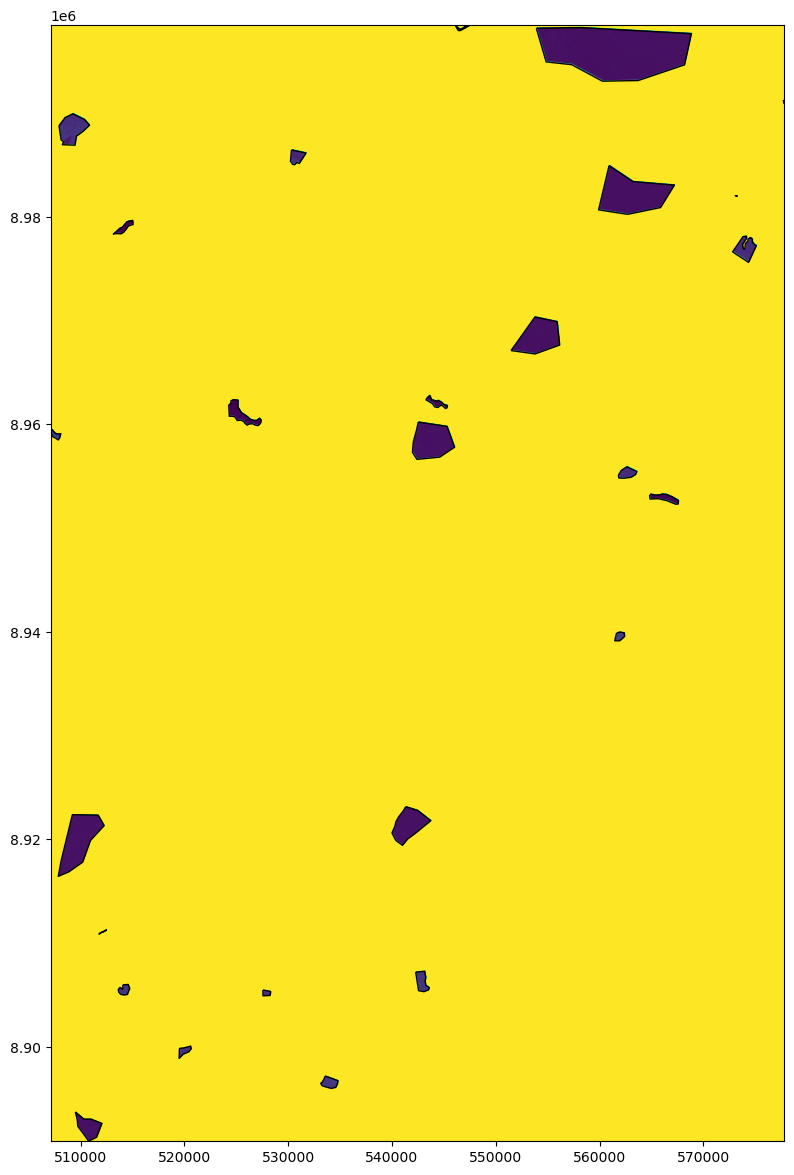

In [24]:
# Cropped
fig, ax = plt.subplots(figsize=(14.5, 14.5))
rasterio.plot.show(out_image_crop[4,:,:], transform=out_transform_crop, ax=ax)
poligonos.plot(ax=ax, color='none', edgecolor='black');

## Extracción de Información Espectral

In [25]:
resultados_estadisticos1 = rasterstats.zonal_stats(
    poligonos, 
    zona_estudio.read(4), 
    nodata = zona_estudio.nodata, 
    affine = zona_estudio.transform, 
    stats = ['mean', 'min', 'max']
)
pd.DataFrame(resultados_estadisticos1)

,min,max,mean
0,1085.0,2223.0,1332.701863
1,255.0,829.0,360.270541
2,260.0,985.0,351.654438
3,270.0,872.0,361.976752
4,282.0,803.0,384.152826
5,292.0,801.0,382.051894
6,272.0,657.0,365.233887
7,306.0,673.0,397.595846
8,1233.0,2049.0,1502.992553
9,745.0,1887.0,1426.630480


In [26]:
resultados = rasterstats.zonal_stats(
    poligonos, 
    zona_estudio.read(5), 
    nodata = zona_estudio.nodata, 
    affine = zona_estudio.transform, 
    interpolate='nearest'
)
pd.DataFrame(resultados)

,min,max,mean,count
0,1584.0,2186.0,1759.256729,7728
1,409.0,1094.0,672.407662,581506
2,449.0,931.0,653.926516,195826
3,423.0,1048.0,669.869446,107021
4,494.0,1009.0,706.479258,133452
5,489.0,1021.0,695.713755,72976
6,454.0,950.0,689.447864,109292
7,488.0,909.0,696.056023,35432
8,1442.0,2237.0,1697.108132,6714
9,1214.0,2210.0,1654.682554,3399


## Análisis Espectral

In [30]:
Datos = pd.read_csv("Datos/Datos_Entrenamiento.csv")
Datos = Datos.drop(columns = ["Unnamed: 0"])
Datos.head()

,Band01,Band02,Band03,Band04,Band05,Band06,Band07,Band08,Band8A,Band09,Band10,Band11,Band12,NDVI,Cobertura
0,1306.0,1383.0,1651.0,2609.0,2031.0,2363.0,2474.0,2947.0,2607.0,597.0,16.0,3690.0,2638.0,-0.000383,Road
1,1306.0,1400.0,1673.0,2612.0,2031.0,2363.0,2474.0,3108.0,2607.0,597.0,16.0,3690.0,2638.0,-0.000958,Road
2,1306.0,1423.0,1646.0,2597.0,2437.0,2698.0,2949.0,3208.0,3077.0,597.0,16.0,3987.0,2798.0,0.084596,Road
3,1306.0,1411.0,1668.0,2657.0,2437.0,2698.0,2949.0,3124.0,3077.0,597.0,16.0,3987.0,2798.0,0.073247,Road
4,1291.0,1384.0,1650.0,2676.0,2431.0,2573.0,2990.0,3103.0,3037.0,623.0,16.0,4098.0,3060.0,0.063189,Road


<Axes: xlabel='Band05', ylabel='Band07'>

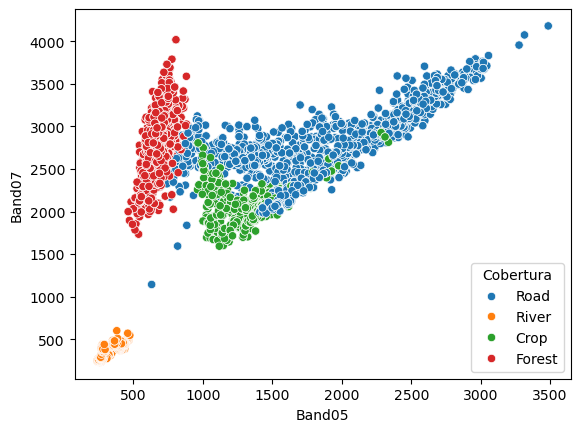

In [34]:
#Datos.plot.scatter(x = "Band05", y = "Band07")
sns.scatterplot(x = "Band05", y = "Band07", data = Datos, hue = "Cobertura")